In [1]:
#! pip install plotly==5.10.0
#pip install dash
!pip install ChernoffFace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


All dependencies


In [2]:

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from ChernoffFace import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Loading data

In [3]:
df_product=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Term 2/Data Viz./Assignment_3/products.csv")
df_review=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Term 2/Data Viz./Assignment_3/reviews.csv")

Preparing the product data

In [4]:
list_product_name=df_product['product_name'].to_list()
li_product_brand=[]
li_product_description=[]
li_product_quantity=[]
for i in list_product_name:
  components=i.split(',')
  li_product_brand.append((components[0]).title())
  li_product_quantity.append(int(((components[-1]).strip()).split(" ")[0]))
  li_product_description.append(components[1:-1])

df_product['product_quantity']=li_product_quantity
df_product['product_brand']=li_product_brand

df_product=df_product.drop(['product_availability','source_url','product_url'], axis=1)

df_test=df_product.groupby('product_brand',as_index=False)[['product_quantity', 'product_price']].sum()
df_test['product_price_per_unit']=df_test['product_price']/df_test['product_quantity']

Preparing the review data

In [5]:
import math
li_original_review_text=df_review['reviewText'].to_list()
li_translated_review_text=df_review['translation.reviewText'].to_list()
li_review_text=[]

for i in range(len(li_original_review_text)):
  if isinstance(li_translated_review_text[i], str):
    li_review_text.append(li_translated_review_text[i])
  else:
     li_review_text.append(li_original_review_text[i])

df_review['review']=li_review_text

df_review['reviewTitle'][df_review['languageCode.1']!='en-US']=''

df_review.loc[df_review['ratingValue']>=40,'sentiment']='Happy'
df_review.loc[df_review['ratingValue']==30,'sentiment']='Neutral'
df_review.loc[df_review['ratingValue']<=20,'sentiment']='Unhappy'

reviewLength=[]
log_reviewLength=[]
for i in df_review['review'].to_list():
  reviewLength.append(len(i.split(" ")))
  log_reviewLength.append(math.log(len(i.split(" ")),10))
df_review['reviewLength']=reviewLength
df_review['log_reviewLength']=log_reviewLength

In [6]:
df_product.rename(columns={'product_id':'productId'}, inplace=True)
df_unified=df_product.merge(df_review, on="productId")

df_unified['helpfullnessRatio']=df_unified['helpfulYes']/(df_unified['helpfulYes']+df_unified['helpfulNo'])

lengthCategory=[]
for i in df_unified['reviewLength'].to_list():
  if i<=50:
    lengthCategory.append('Upto 50 words')
  elif i>50 and i<=100:
    lengthCategory.append('Between 50 and 100 words')
  elif i>100 and i<=200:
    lengthCategory.append('Between 100 and 200 words')
  else:
    lengthCategory.append("Above 200 words")

df_unified['lengthCategory']=lengthCategory

postedYear=[]
for i in df_unified['postedDate'].to_list():
  postedYear.append((i.split("T")[0]).split("-")[0]+"-"+(i.split("T")[0]).split("-")[1]+"-01")

df_unified['postedYear']=postedYear
  

  # Q1) What is the price of a mask sold by each brand?

In [7]:
fig = px.bar(df_test, y='product_price_per_unit', x='product_brand', 
            title="Cost per unit of a mask for each brand",
            text='product_price_per_unit',
            labels={'product_price_per_unit':'Price of each mask','product_brand':'Brand'})
fig.update_traces(texttemplate='$'+'%{text:.2f}', textposition='outside',marker_color='salmon',textfont_size=12, textangle=0, cliponaxis=False)
fig.update_layout(barmode='stack', xaxis={'categoryorder': 'total ascending'},xaxis_tickangle=-45, yaxis_tickprefix='$', yaxis_tickformat=',.', title_x=0.5, font_size=15)
fig.show()

# Q2) What are the most common words in different kinds of reviews?

In [8]:
def remove_spaces(text):
    text=text.strip()
    text=text.split()
    return ' '.join(text)

def edits1(word):
    letters='abcdefghijklmnopqrstuvwxyz'
    splits=[(word[:i], word[i:]) for i in range(len(word)+1)]
    deletes=[L+R[1:] for L,R in splits if R]
    transposes=[L+R[1] +R[0] + R[2:] for L,R in splits if len(R)>1]
    replaces = [L+c+R[1:] for L,R in splits if R for c in letters]
    inserts = [L+c+ R for L,R in splits for c in letters]
    return set(deletes+transposes+replaces+inserts)
def edits2(word):
    return(e2 for e1 in edits1(word) for e2 in edits1(e1))

contraction_blacklist = {'cause':'because',
              'aint': 'am not',
              'aren\'t': 'are not',
              'mask':' ',
              'masks':' ',
              'nose':' ',
              'face':' '}

def mapping_replacer(x,dic):
    for words in dic.keys():
        if ' ' + words + ' ' in x:
            x=x.replace(' '+ words +' ' ,' '+dic[words]+' ' )
    return x

nltk.LancasterStemmer
ls = LancasterStemmer()
lem = WordNetLemmatizer()
def lexicon_normalization(text):
    words = word_tokenize(text) 
    
    
    # 1- Stemming
    words_stem = [ls.stem(w) for w in words]
    
    # 2- Lemmatization
    words_lem = [lem.lemmatize(w) for w in words_stem]
    return words_lem

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\'','', text)
    return text

def remove_stopword(text):
    stop_words = stopwords.words('english')
    stopwords_dict = Counter(stop_words)
    text = ' '.join([word for word in text.split() if word not in stopwords_dict])
    return text

def tokenise(text):
    words = word_tokenize(text) 
    return words

import re
df_review_word=df_review[['review', 'ratingValue', 'sentiment']]
df_review_word['review'] = df_review_word['review'].map(lambda x: re.sub(r'\W+', ' ', x))
df_review_word['review'] = df_review_word['review'].replace(r'\W+', ' ', regex=True)
df_review_word['review']=df_review_word['review'].apply(lambda x: mapping_replacer(x, contraction_blacklist))
df_review_word['review'] = df_review_word['review'].apply(lambda x:clean_text(x))
df_review_word['review']=df_review_word['review'].apply(lambda x: remove_stopword(x))

In [9]:
top = Counter([item for sublist in df_review_word['review'][(df_review_word['sentiment']=='Happy')].to_list() for item in sublist.split(" ")])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
#temp.style.background_gradient(cmap='Blues')

fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25), font_size=15, title_x=0.5)
fig.update_traces(marker_colors=["black","red","pink", "royalblue", "wheat", "purple", "salmon","azure","bisque"
                     "ivory", "brown", "lightblue", "lightgreen","grey","yellow","orange","gold","khaki","silver","lime"],
                  text=[''], textfont_size=25, textposition='middle center')
fig.show()

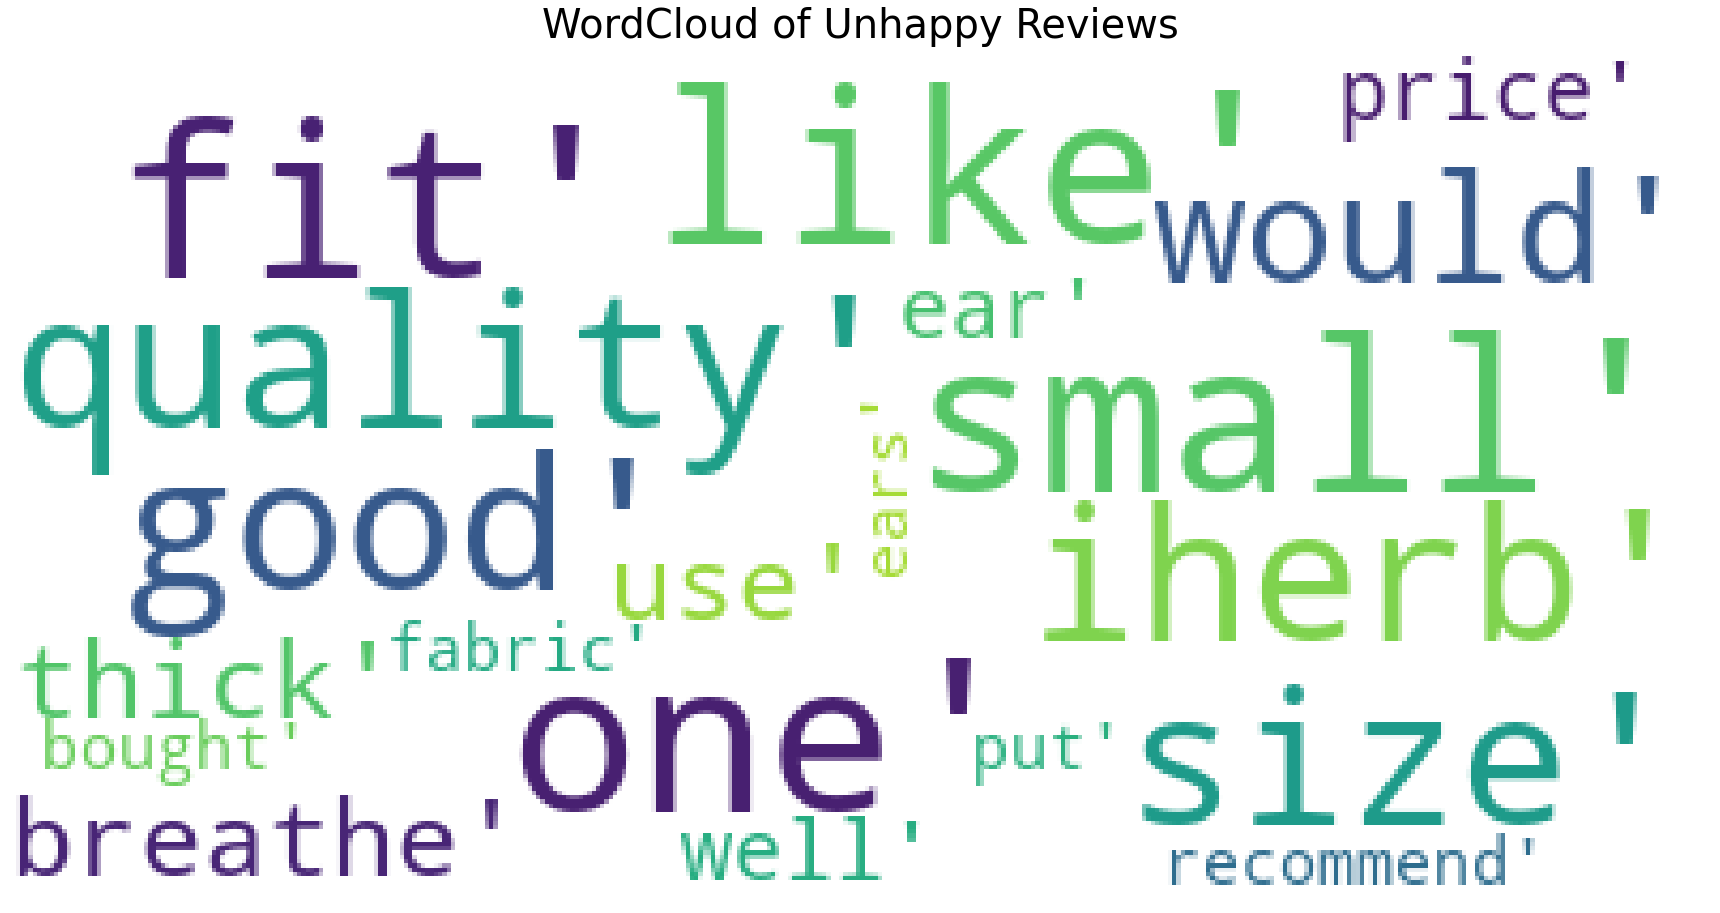

In [10]:
def plot_wordcloud(text, mask=None, max_words=20, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    
    wordcloud = WordCloud(background_color=color,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  


top = Counter([item for sublist in df_review_word['review'][(df_review_word['sentiment']=='Unhappy')].to_list() for item in sublist.split(" ")])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
#temp.style.background_gradient(cmap='Blues')

plot_wordcloud(temp['Common_words'].to_list(),color='white',max_font_size=50,title_size=40,title="WordCloud of Unhappy Reviews")

# Q3) Which Rating got Highest Number of Review Length?

In [11]:
fig = go.Figure()

fig.add_trace(go.Box(
    y=df_review['reviewLength'][(df_review['ratingValue']==10)],
    name="10",
    marker_color = 'lightseagreen'
))

fig.add_trace(go.Box(
    y=df_review['reviewLength'][(df_review['ratingValue']==20)],
    name="20",
    
))

fig.add_trace(go.Box(
    y=df_review['reviewLength'][(df_review['ratingValue']==30)],
    name="30",
    marker_color = 'lightseagreen'
))

fig.add_trace(go.Box(
    y=df_review['reviewLength'][(df_review['ratingValue']==40)],
    name="40",
    marker_color = 'lightseagreen'
))

fig.add_trace(go.Box(
    y=df_review['reviewLength'][(df_review['ratingValue']==50)],
    name="50",
    marker_color = 'lightseagreen'
))

fig.update_layout(
    yaxis_title='Review length',
    xaxis_title=' Ratings',
    font_size=15,
    showlegend=False,
    title="Review Length v/s Ratings",
    title_x=0.5
    #boxmode='group' # group together boxes of the different traces for each value of x
)
fig.update_yaxes(
    tickangle=0,
    title='Review length',
    #type='log'
)
fig.show()

# Q4) Are long reviews generally written for critical reviews?

In [12]:
count_positive={"Upto 50 words":0,"Between 50 & 100 words":0,"Between 100 & 200 words":0,"Above 200 words":0}
count_negative={"Upto 50 words":0,"Between 50 & 100 words":0,"Between 100 & 200 words":0,"Above 200 words":0}
count_neutral={"Upto 50 words":0,"Between 50 & 100 words":0,"Between 100 & 200 words":0,"Above 200 words":0}

In [13]:
for i, j in zip(df_unified['reviewLength'].to_list(),df_unified['sentiment'].to_list()):
  if i<=50:
    if j=="Happy":
      count_positive["Upto 50 words"]+=1
    elif j=="Unhappy":
      count_negative["Upto 50 words"]+=1
    elif j=="Neutral":
      count_neutral["Upto 50 words"]+=1
  if i>50 and i<=100:
    if j=="Happy":
      count_positive["Between 50 & 100 words"]+=1
    elif j=="Unhappy":
      count_negative["Between 50 & 100 words"]+=1
    elif j=="Neutral":
      count_neutral["Between 50 & 100 words"]+=1
  if i>100 and i<=200:
    if j=="Happy":
      count_positive["Between 100 & 200 words"]+=1
    elif j=="Unhappy":
      count_negative["Between 100 & 200 words"]+=1
    elif j=="Neutral":
      count_neutral["Between 100 & 200 words"]+=1
  if i>200:
    if j=="Happy":
      count_positive["Above 200 words"]+=1
    elif j=="Unhappy":
      count_negative["Above 200 words"]+=1
    elif j=="Neutral":
      count_neutral["Above 200 words"]+=1



In [14]:
x = ["Upto 50 words", "Between 50 and 100 words", "Between 100 and 200 words", 'Above 200 words']

fig = go.Figure()
fig.add_trace(go.Bar(x=x,
                y=list(count_positive.values()),
                name='Happy',
                marker_color='cornflowerblue',
                text='Happy',
                #text_auto=True
                textposition = 'inside',
                insidetextanchor = 'middle',
                textangle=360,
                textfont_size=10
                ))
fig.add_trace(go.Bar(x=x,
                y=list(count_neutral.values()),
                name='Neutral',
                marker_color='lightseagreen',
                text='Neutral',
                textposition = 'inside',
                insidetextanchor = 'middle',
                textangle=360,
                textfont_size=10
                ))
fig.add_trace(go.Bar(x=x,
                y=list(count_negative.values()),
                name='Unhappy',
                text='Unhappy',
                marker_color='salmon',
                textposition = 'inside',
                insidetextanchor = 'middle',
                textangle=360,
                textfont_size=10
                ))

fig.update_layout(
    yaxis_title='Count of reviews',
    xaxis_title='Review Length',
    font_size=15,
    showlegend=False,
    title="Review Length v/s Sentiments",
    title_x=0.5,
    yaxis1=dict(type='log'),
    xaxis_tickfont_size=14,
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

# Q5) Is there any relation between the length of the review and the rating?

In [15]:
df_test=df_unified.groupby('reviewLength', as_index=False)[['ratingValue']].mean()

lengthCategory=[]
for i in df_test['reviewLength'].to_list():
  if i<=50:
    lengthCategory.append('Upto 50 words')
  elif i>50 and i<=100:
    lengthCategory.append('Between 50 and 100 words')
  elif i>100 and i<=200:
    lengthCategory.append('Between 100 and 200 words')
  else:
    lengthCategory.append("Above 200 words")

df_test['lengthCategory']=lengthCategory

fig = px.scatter(df_test, x='reviewLength', y='ratingValue', symbol='lengthCategory', color='lengthCategory', marginal_x="histogram" )
fig.update_layout(
    yaxis_title='Rating Value',
    xaxis_title='Review Length',
    font_size=15,
    showlegend=True,
    title="Review Length v/s Rating Value",
    title_x=0.5,
    xaxis_tickfont_size=14,
)
fig.show()

# Q6) How are the 'Happy', 'Unhappy', and 'Neutral' reviews distributed for each brand?

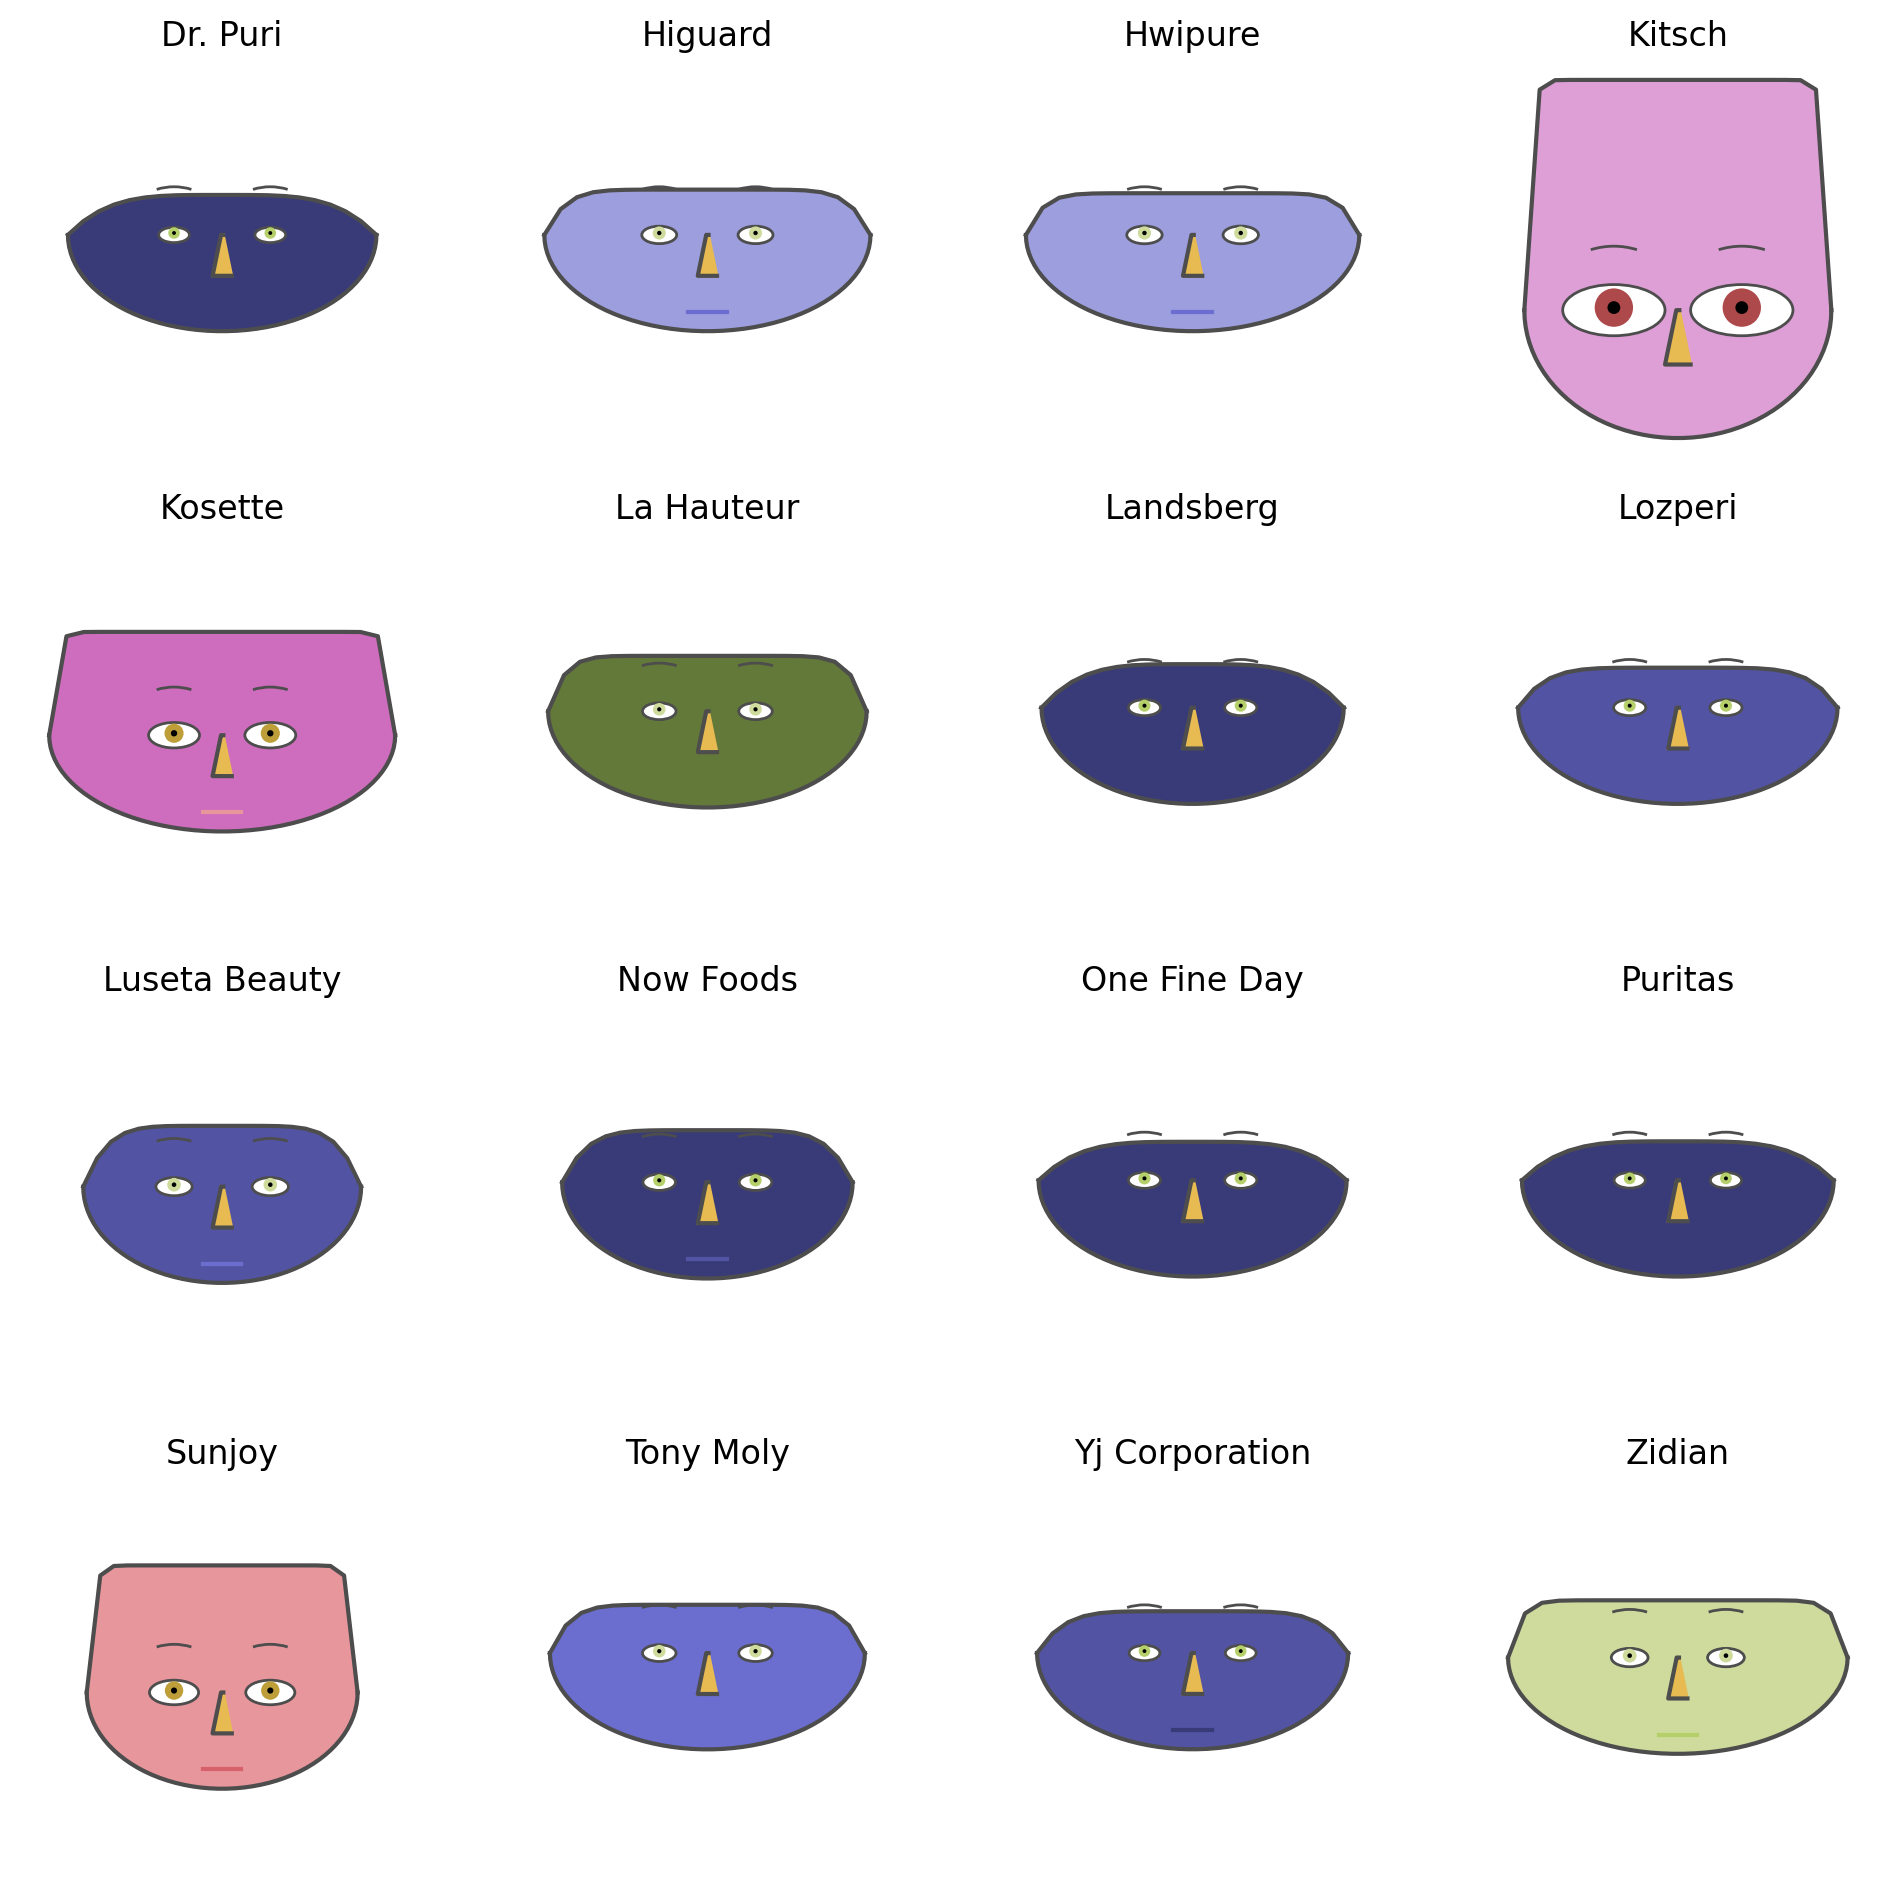

In [16]:
df_chernoff=(df_unified.groupby('product_brand', as_index=False)['sentiment'].count())
df_chernoff['Happy']=df_unified[df_unified['sentiment']=='Happy'].groupby('product_brand', as_index=False)['sentiment'].count()['sentiment'].to_list()
df_chernoff['Unhappy']=df_unified[df_unified['sentiment']=='Unhappy'].groupby('product_brand', as_index=False)['sentiment'].count()['sentiment'].to_list()
df_chernoff['Neutral']=df_unified[df_unified['sentiment']=='Neutral'].groupby('product_brand', as_index=False)['sentiment'].count()['sentiment'].to_list()

df_chernoff_scaled = variables_rescale(df_chernoff)

fig = chernoff_face(data=df_chernoff_scaled,
                    n_columns=4,
                    long_face=False,
                    titles=df_chernoff['product_brand'].to_list(),
                    color_mapper=matplotlib.cm.tab20b,
                    figsize=(12, 12), dpi=200,
                    )



#Q7) What are the top 5 brands with the best reviews?

In [17]:
df_chernoff=(df_unified.groupby('product_brand', as_index=False)['sentiment'].count())
df_chernoff['Happy']=df_unified[df_unified['sentiment']=='Happy'].groupby('product_brand', as_index=False)['sentiment'].count()['sentiment'].to_list()
df_chernoff['Unhappy']=df_unified[df_unified['sentiment']=='Unhappy'].groupby('product_brand', as_index=False)['sentiment'].count()['sentiment'].to_list()
df_chernoff['Neutral']=df_unified[df_unified['sentiment']=='Neutral'].groupby('product_brand', as_index=False)['sentiment'].count()['sentiment'].to_list()
df_chernoff['Happy']=round(df_chernoff['Happy']/df_chernoff['sentiment']*100,2)
df_chernoff['Unhappy']=round(df_chernoff['Unhappy']/df_chernoff['sentiment']*100,2)
df_chernoff['Neutral']=round(df_chernoff['Neutral']/df_chernoff['sentiment']*100,2)

df_top_5=df_chernoff.sort_values('Happy', ascending=False).head(5)

x = df_top_5['product_brand'].to_list()
y1=df_top_5['Happy'].to_list()
y2=df_top_5['Neutral'].to_list()
y3=df_top_5['Unhappy'].to_list()

fig = go.Figure()
fig.add_trace(go.Bar(x=x,
                y=y1,
                name='Happy',
                marker_color='cornflowerblue',
                texttemplate="%{y}"+"%",
                textposition = 'inside',
                insidetextanchor = 'middle',
                textangle=360,
                textfont_size=20
                ))
fig.add_trace(go.Bar(x=x,
                y=y2,
                name='Neutral',
                marker_color='lightseagreen',
                texttemplate="%{y}"+"%",
                textposition = 'inside',
                insidetextanchor = 'middle',
                textangle=360,
                textfont_size=15
                ))
fig.add_trace(go.Bar(x=x,
                y=y3,
                name='Unhappy',
                texttemplate="%{y}"+"%",
                marker_color='salmon',
                textposition = 'inside',
                insidetextanchor = 'middle',
                textangle=360,
                textfont_size=15
                ))

fig.update_layout(
    yaxis_title='Percentage of reviews',
    xaxis_title='Brand',
    font_size=15,
    showlegend=True,
    title="Top 5 best reviewed mask brand",
    title_x=0.5,
    yaxis1=dict(type='log'),
    xaxis_tickfont_size=14,
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

# Q8) Is abuse count high in long reviews ? Is abuse count high in Unhappy reviews?

In [18]:
df_abuse_sentiment=(df_unified.groupby('sentiment', as_index=False)[['productId']].count()).merge(df_unified.groupby('sentiment', as_index=False)[['abuseCount']].sum(), on="sentiment")
df_abuse_sentiment['proportion_of_abuse_in_category']=df_abuse_sentiment['abuseCount']/df_abuse_sentiment['productId']
df_abuse_sentiment=df_abuse_sentiment.sort_values('proportion_of_abuse_in_category', ascending=False)

df_abuse_unified=(df_unified.groupby('lengthCategory', as_index=False)[['productId']].count()).merge(df_unified.groupby('lengthCategory', as_index=False)[['abuseCount']].sum(), on="lengthCategory")
df_abuse_unified['proportion_of_abuse_in_category']=df_abuse_unified['abuseCount']/df_abuse_unified['productId']
df_abuse_unified=df_abuse_unified.sort_values('proportion_of_abuse_in_category', ascending=False)

fig = go.Figure()

fig.add_trace(go.Funnelarea(
    values = df_abuse_sentiment['proportion_of_abuse_in_category'].to_list(), text = ["Neutral", "Unhappy", "Happy"],
    marker = {"colors": ["cornflowerblue", "lightseagreen", "salmon","yellow"],
                "line": {"color": ["red", "red", "red"], "width": [5, 0, 0]}},
    textfont = {"family": "Old Standard TT, serif", "size": 20, "color": "black"}, opacity = 0.65,
    title = {"position": "top center", "text": "Abuse count v/s Sentiment", "font_size":20},
    domain = {"x": [0, 0.5], "y": [0, 0.95]}))
    

fig.add_trace(go.Funnelarea(
    values = df_abuse_unified['proportion_of_abuse_in_category'], text = ["Between 100 and 200 words","Above 200 words","Between 50 and 100 words","Upto 50 words" ],
    marker = {"colors": ["cornflowerblue", "lightseagreen", "salmon","yellow"],
                "line": {"color": ["red", "red", "red"], "width": [5, 0, 0]}},
    textfont = {"family": "Old Standard TT, serif", "size": 20, "color": "black"}, opacity = 0.65,
    title = {"position": "top left", "text": "Abuse count v/s Review length", "font_size":20},
    domain = {"x": [0.55, 1], "y": [0, 0.95]}))

fig.update_layout(
            title_text="Abuse count v/s Sentiment & Review Length",
            title_x=0.5,
            font_size=15,
            margin = {"l": 200, "r": 200}, shapes = [
            {"x0": 0, "x1": 0.5, "y0": 0, "y1": 1},
            {"x0": 0.55, "x1": 1, "y0": 0, "y1": 1},]
            )



In [19]:
df_characteristics=df_unified[['sentiment','lengthCategory','helpfulYes']].sort_values('helpfulYes', ascending=False).head(10)
di_sentiment=df_characteristics['sentiment'].value_counts().to_dict()
di_length=df_characteristics['lengthCategory'].value_counts().to_dict()

label1 = ["Happy","Unhappy","Neutral"]

label2 = ["Upto 50 words","Between 50 and 100 words","Between 100 and 200 words"]

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=label1, values=list(di_sentiment.values()), name="Sentiment",text=["Happy","Unhappy","Neutral"],textposition="outside", textfont_size=15),
              1, 1)
fig.add_trace(go.Pie(labels=label2, values=list(di_length.values()), name="Review Length", text=label2, textposition="outside", textfont_size=15),
              1, 2)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Characteristics of top 10 most helpful reviews",
    title_x=0.5,
    font_size=15,
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Sentiment', x=0.19, y=0.5, font_size=15, showarrow=False),
                 dict(text='Review Length', x=0.83, y=0.5, font_size=15, showarrow=False)],
    showlegend=False,
                  )
fig.show()

# Q10) Did the review count increase as the cases of covid increased worldwide?

In [20]:
df_1=df_unified.sort_values('postedYear').groupby('postedYear', as_index=False)[['review']].count()

df_covid=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Term 2/Data Viz./Assignment_3/owid-covid-data.csv")
list_year=[]
for i in df_covid['date'].to_list():
  list_year.append((i.split("-")[2]+"-"+i.split("-")[1]+"-01"))
df_covid['postedYear']=list_year

df_covid_total=df_covid.groupby('postedYear', as_index=False)[['total_cases']].sum()
start_date = '2020-05-01'
end_date = '2021-02-01'
df_covid_total= df_covid_total[(df_covid_total['postedYear'] >= start_date) & (df_covid_total['postedYear'] <= end_date)]
df_covid_total['total_case_in_millions']=(df_covid_total['total_cases'].astype(float)/1000000)

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_1['postedYear'].to_list(), y=df_1['review'].to_list(), name="Review count",line=dict(dash='dash')),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_covid_total['postedYear'].to_list(), y=df_covid_total['total_case_in_millions'].to_list(), name="Covid cases",line=dict(dash='dash')),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Review count v/s Covid cases along the timeline",
    title_x=0.5,
    font_size=15
)

# Set x-axis title
#fig.update_xaxes(title_text="xaxis title")

# Set y-axes titles
fig.update_yaxes(title_text="Count of reviews", secondary_y=False)
fig.update_yaxes(title_text="Covid cases (in millions)", secondary_y=True)

fig.show()